In [1]:
from mytorch.loss import CrossEntropyLoss
from mytorch.optim import Adam
from mytorch.dataloader import Dataloader
import numpy as np
import random
import pickle
from model import Model
from matplotlib import pyplot as plt

In [2]:
class Dataset:
    def __init__(self, img, target, transform=None):
        self.img = img
        self.target = target
        self.transform = transform
    
    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img = self.img[idx]
        if self.transform:
            img = self.transform(images = img.astype(np.uint8))
        img = (img-img.min())/img.max()
        target = self.target[idx]
        target = target*0.9+0.1/15.
        return img, target

In [3]:
def random_split(data, target, length):
    indices = list(range(len(data)))
    random.shuffle(indices)
    train_len = int(len(data)*length)
    val_len = len(data)-train_len
    train_data = [data[indices[i]] for i in range(train_len)]
    train_target = [target[indices[i]] for i in range(train_len)]
    val_data = [data[indices[i]] for i in range(train_len, train_len+val_len)]
    val_target = [target[indices[i]] for i in range(train_len, train_len+val_len)]
    return train_data, train_target, val_data, val_target

In [4]:
def accuracy(pred, target):
    y = np.argmax(pred.a, axis=1)
    t = np.argmax(target.a, axis=1)
    count = np.where(y == t, 1, 0)
    count = np.sum(count)
    return count/len(pred.a)

In [5]:
epoch = 300
batch_size = 32
lr = 1e-2
train_length = 0.8
path = "./weights/"

In [6]:
import imgaug.augmenters as iaa
augseq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.03)),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Affine(
    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
    rotate=(-15, 15),
    shear=(-3, 3)
    ),
    ], random_order=True
)
model = Model()
celoss = CrossEntropyLoss()
optim = Adam(model.get_params(), lr=lr)

train_data = np.load("./1_data/train_data.npy")
train_label = np.load("./1_data/train_label.npy")
train_x, train_y, val_x, val_y = random_split(train_data, train_label, train_length)
train_dataset = Dataset(train_x, train_y, augseq)
val_dataset = Dataset(val_x, val_y)
dataloader = Dataloader(train_dataset, batch_size, True)
val_dataloader = Dataloader(val_dataset)
size = len(train_dataset)

In [7]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for e in range(epoch):
    progress = 0
    model.train()
    t_ac = 0
    t_loss = 0
    i = 0
    for x, target in dataloader:
        i += 1
        progress += batch_size
        optim.zero_grad()
        y = model(x)
        loss = celoss(y, target)
        loss.backward()
        optim.step()
        bar = int(progress/size*40)
        t_ac += accuracy(y, target)
        t_loss += float(loss.a)
        if (model.conv1.weight.grad.max() < 1e-10):
            print(" !! conv1.weight.grad zero")
        print("\r{}/{}[{}]loss: {} accuracy: {}".format(e,epoch,"="*bar+"-"*(40-bar),t_loss/i, t_ac/i), end="")
        del loss
    t_ac /= i+1e-7
    t_loss /= i+1e-7
    v_ac = 0
    v_loss = 0
    i = 0
    model.eval()
    for val_x, val_y in val_dataloader:
        i += 1
        y = model(val_x)
        v_ac += accuracy(y, val_y)
        v_loss += float(celoss(y, val_y).a)
    v_ac /= i+1e-7
    v_loss /= i+1e-7
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    train_accuracies.append(t_ac)
    val_accuracies.append(v_ac)
    print(f"\nloss: {t_loss}, val_loss: {v_loss}, accuracy: {t_ac}, val_accuracy: {v_ac}")
    if (e+1)%10 == 0:
        with open(path+f"{e}_weights{v_ac}.pkl", "wb") as f:
            pickle.dump(model.state_dict(), f)

0/300[========================================]loss: 1.8502001677031634 accuracy: 0.091666666666666664
loss: 1.8502001652362299, val_loss: 1.8261937500736547, accuracy: 0.09166666654444446, val_accuracy: 0.12135416545312502
1/300[========================================]loss: 1.8360871809457915 accuracy: 0.10416666666666667
loss: 1.8360871784976753, val_loss: 1.8055185810334295, accuracy: 0.10416666652777778, val_accuracy: 0.12135416545312502
2/300[========================================]loss: 1.8150031224452625 accuracy: 0.09833333333333333
loss: 1.8150031200252585, val_loss: 1.8119005963495687, accuracy: 0.09833333320222223, val_accuracy: 0.09687499903125002
3/300[========================================]loss: 1.804127016893259 accuracy: 0.106666666666666671
loss: 1.8041270144877564, val_loss: 1.7809049998687243, accuracy: 0.10666666652444445, val_accuracy: 0.09218749907812501
4/300[========================================]loss: 1.797107374152823 accuracy: 0.106666666666666671
loss:

37/300[========================================]loss: 1.3829214126649116 accuracy: 0.5116666666666667
loss: 1.3829214108210166, val_loss: 1.395759920916074, accuracy: 0.5116666659844444, val_accuracy: 0.4541666621250001
38/300[========================================]loss: 1.3549917809589318 accuracy: 0.5391385135135135
loss: 1.354991779152276, val_loss: 1.3418524439056103, accuracy: 0.5299999992933334, val_accuracy: 0.4968749950312501
39/300[========================================]loss: 1.3248602710005308 accuracy: 0.5466666666666666
loss: 1.3248602692340508, val_loss: 1.3006160368430006, accuracy: 0.5466666659377778, val_accuracy: 0.5312499946875001
40/300[========================================]loss: 1.298631615745206 accuracy: 0.55541666666666673
loss: 1.2986316140136973, val_loss: 1.3087781078872696, accuracy: 0.5554166659261112, val_accuracy: 0.494270828390625
41/300[========================================]loss: 1.2620148915173586 accuracy: 0.5758333333333333
loss: 1.262014889

74/300[========================================]loss: 0.7888742951469303 accuracy: 0.8441666666666666
loss: 0.7888742940950979, val_loss: 0.7029012412628205, accuracy: 0.8441666655411112, val_accuracy: 0.9119791575468751
75/300[========================================]loss: 0.7907873434929523 accuracy: 0.8445833333333334
loss: 0.7907873424385693, val_loss: 0.6870706314043709, accuracy: 0.8445833322072223, val_accuracy: 0.9333333240000002
76/300[========================================]loss: 0.7854517647519106 accuracy: 0.8551520270270278
loss: 0.7854517637046416, val_loss: 0.6832675284727122, accuracy: 0.8549999988600001, val_accuracy: 0.929166657375
77/300[========================================]loss: 0.777494558570463 accuracy: 0.86166666666666674
loss: 0.7774945575338037, val_loss: 0.6792982910800922, accuracy: 0.8616666655177778, val_accuracy: 0.9244791574218751
78/300[========================================]loss: 0.7736077794434859 accuracy: 0.8608333333333333
loss: 0.7736077784

111/300[========================================]loss: 0.6731270882169412 accuracy: 0.9054054054054054
loss: 0.6731270873194385, val_loss: 0.6130019948400554, accuracy: 0.9049999987933334, val_accuracy: 0.9458333238750002
112/300[========================================]loss: 0.6603049191540371 accuracy: 0.9187535135135135
loss: 0.6603049182736306, val_loss: 0.6228220352901372, accuracy: 0.9187499987750001, val_accuracy: 0.9395833239375002
113/300[========================================]loss: 0.6645438675490474 accuracy: 0.9116666666666666
loss: 0.6645438666629889, val_loss: 0.618247056647516, accuracy: 0.9116666654511112, val_accuracy: 0.9395833239375002
114/300[========================================]loss: 0.666404510285436 accuracy: 0.90583333333333341
loss: 0.6664045093968968, val_loss: 0.6485978190304149, accuracy: 0.9058333321255556, val_accuracy: 0.9317708240156252
115/300[========================================]loss: 0.6590613969683133 accuracy: 0.9166666666666666
loss: 0.65

148/300[========================================]loss: 0.598782911756886 accuracy: 0.94546790540540541
loss: 0.5987829109585089, val_loss: 0.5966608314144863, accuracy: 0.9449999987400001, val_accuracy: 0.9567708237656252
149/300[========================================]loss: 0.6081297026748705 accuracy: 0.9408333333333333
loss: 0.6081297018640309, val_loss: 0.5934153864111092, accuracy: 0.940833332078889, val_accuracy: 0.9640624903593752
150/300[========================================]loss: 0.597430481611949 accuracy: 0.94594594594594594
loss: 0.5974304808153751, val_loss: 0.5873783218933085, accuracy: 0.9449999987400001, val_accuracy: 0.9609374903906251
151/300[========================================]loss: 0.599716583067376 accuracy: 0.94416666666666678
loss: 0.5997165822677539, val_loss: 0.6045102870241418, accuracy: 0.9441666654077778, val_accuracy: 0.9546874904531252
152/300[========================================]loss: 0.5937511625393735 accuracy: 0.9491666666666667
loss: 0.59

185/300[========================================]loss: 0.5539376889582102 accuracy: 0.9666666666666667
loss: 0.5539376882196265, val_loss: 0.5556926997860825, accuracy: 0.9666666653777779, val_accuracy: 0.9739583235937502
186/300[========================================]loss: 0.5571696542699742 accuracy: 0.9662521621621622
loss: 0.5571696535270814, val_loss: 0.5948009402387769, accuracy: 0.9662499987116667, val_accuracy: 0.9531249904687501
187/300[========================================]loss: 0.5601578384677175 accuracy: 0.9659391891891942
loss: 0.5601578377208404, val_loss: 0.5692143029443607, accuracy: 0.9649999987133334, val_accuracy: 0.9671874903281251
188/300[========================================]loss: 0.5481647084969402 accuracy: 0.9666666666666667
loss: 0.548164707766054, val_loss: 0.5453448477437035, accuracy: 0.9666666653777779, val_accuracy: 0.9765624902343751
189/300[========================================]loss: 0.5507674045935431 accuracy: 0.9666666666666667
loss: 0.55

222/300[========================================]loss: 0.5250146351437812 accuracy: 0.9795833333333334
loss: 0.5250146344437618, val_loss: 0.5444916524861814, accuracy: 0.9795833320272223, val_accuracy: 0.9687499903125002
223/300[========================================]loss: 0.5207269192347938 accuracy: 0.9833333333333333
loss: 0.5207269185404912, val_loss: 0.5548576749859155, accuracy: 0.9833333320222223, val_accuracy: 0.9624999903750001
224/300[========================================]loss: 0.5214035079453724 accuracy: 0.9841666666666666
loss: 0.5214035072501677, val_loss: 0.5448026262682402, accuracy: 0.9841666653544445, val_accuracy: 0.9703124902968752
225/300[========================================]loss: 0.5239076261579607 accuracy: 0.9787551351351351
loss: 0.5239076254594173, val_loss: 0.5463710710490494, accuracy: 0.9787499986950001, val_accuracy: 0.9656249903437502
226/300[========================================]loss: 0.5244910434463996 accuracy: 0.9816666666666667
loss: 0.5

259/300[========================================]loss: 0.5055250050951964 accuracy: 0.9879166666666667
loss: 0.5055250044211631, val_loss: 0.5484678841953963, accuracy: 0.9879166653494446, val_accuracy: 0.9598958237343752
260/300[========================================]loss: 0.5076262013368541 accuracy: 0.9875533783783784
loss: 0.5076262006600192, val_loss: 0.5495001376408867, accuracy: 0.9874999986833334, val_accuracy: 0.9703124902968752
261/300[========================================]loss: 0.5069827906423369 accuracy: 0.9862541891891891
loss: 0.5069827899663598, val_loss: 0.5418771936733686, accuracy: 0.9862499986850001, val_accuracy: 0.9703124902968752
262/300[========================================]loss: 0.5086946060459056 accuracy: 0.98458333333333344
loss: 0.5086946053676461, val_loss: 0.5324123367660104, accuracy: 0.9845833320205556, val_accuracy: 0.9723958236093753
263/300[========================================]loss: 0.5080309424754975 accuracy: 0.98625418918918916
loss: 0

296/300[========================================]loss: 0.49199939314971675 accuracy: 0.9937583783783784
loss: 0.4919993924937176, val_loss: 0.5300429642001797, accuracy: 0.9937499986750001, val_accuracy: 0.9708333236250002
297/300[========================================]loss: 0.4907312083694928 accuracy: 0.99416666666666668
loss: 0.4907312077151846, val_loss: 0.5380310673552999, accuracy: 0.9941666653411112, val_accuracy: 0.9661458236718752
298/300[========================================]loss: 0.49558623290787335 accuracy: 0.9895833333333334
loss: 0.49558623224709175, val_loss: 0.5239234029783552, accuracy: 0.9895833320138889, val_accuracy: 0.9796874902031252
299/300[========================================]loss: 0.4995390639072938 accuracy: 0.99125317567567568
loss: 0.49953906324124175, val_loss: 0.5311404249375654, accuracy: 0.9912499986783334, val_accuracy: 0.9723958236093753


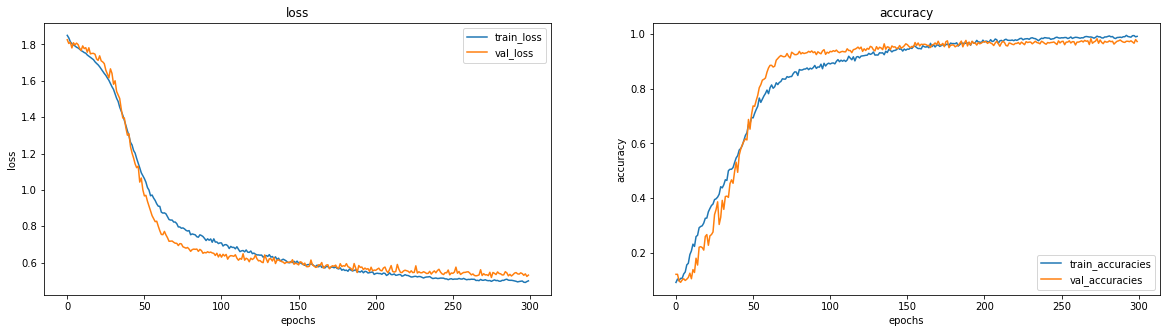

In [8]:
epochs = np.arange(len(train_losses))
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title("loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].plot(epochs, train_losses, label="train_loss")
ax[0].plot(epochs, val_losses, label="val_loss")
ax[0].legend()
ax[1].set_title("accuracy")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].plot(epochs, train_accuracies, label="train_accuracies")
ax[1].plot(epochs, val_accuracies, label="val_accuracies")
ax[1].legend()
plt.show()

In [9]:
dataset = Dataset(train_data, train_label, augseq)
dataloader = Dataloader(train_dataset, batch_size, True)
size = len(train_dataset)
epoch = 100

for e in range(epoch):
    progress = 0
    model.train()
    t_ac = 0
    t_loss = 0
    i = 0
    for x, target in dataloader:
        i += 1
        progress += batch_size
        optim.zero_grad()
        y = model(x)
        loss = celoss(y, target)
        loss.backward()
        optim.step()
        bar = int(progress/size*40)
        t_ac += accuracy(y, target)
        t_loss += float(loss.a)
        if (model.conv1.weight.grad.max() < 1e-10):
            print(" !! conv1.weight.grad zero")
        print("\r{}/{}[{}]loss: {} accuracy: {}".format(e,epoch,"="*bar+"-"*(40-bar),t_loss/i, t_ac/i), end="")
        del loss
    if (e+1)%10 == 0:
        with open(path+f"epoch{e}_weights{t_ac}.pkl", "wb") as f:
            pickle.dump(model.state_dict(), f)

99/100[========================================]loss: 0.47890792748723804 accuracy: 0.9941666666666666